In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

In [17]:
df = pd.read_csv('../data/processedZip_ABCDEats_data.csv')
df

,customer_id,customer_region,customer_age,vendor_count,product_count,is_chain,first_order,last_order,last_promo,payment_method,...,dinner_orders,meal_preference,morning_orders,midday_orders,evening_orders,night_orders,drinking_orders,primary_time_period,area_type,region
0,1b8f824d5e,2360,18,2,5,1,0,1,DELIVERY,DIGI,...,2,dinner,0,0,2,0,0,evening,city,"Plymouth County, MA"
1,5d272b9dcb,8670,17,2,2,2,0,1,DISCOUNT,DIGI,...,0,lunch,1,1,0,0,0,morning,suburban,New Jersey
2,f6d1b2ba63,4660,38,1,2,2,0,1,DISCOUNT,CASH,...,0,lunch,1,1,0,0,0,morning,coastal,Coastal Maine
3,180c632ed8,4660,24,2,3,1,0,2,DELIVERY,DIGI,...,0,lunch,0,2,0,0,0,midday,coastal,Coastal Maine
4,4eb37a6705,4660,20,2,5,0,0,2,-,DIGI,...,0,dinner,2,0,0,0,0,morning,coastal,Coastal Maine
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31732,f4e366c281,8670,30,1,1,1,34,0,FREEBIE,DIGI,...,0,lunch,0,1,0,0,0,midday,suburban,New Jersey
31733,f6b6709018,8670,27,1,1,0,28,0,DELIVERY,DIGI,...,0,dinner,0,0,1,0,0,evening,suburban,New Jersey
31734,f74ad8ce3f,8670,24,1,1,1,12,0,-,DIGI,...,0,dinner,0,0,0,0,1,drinking,suburban,New Jersey
31735,f7b19c0241,8670,34,1,1,0,7,0,DISCOUNT,DIGI,...,0,lunch,0,1,0,0,0,midday,suburban,New Jersey


In [14]:
def prepare_data(df, cuisine_cols):
    # Previous features
    cuisine_features = df[cuisine_cols].div(df['total_orders'], axis=0)
    timing = df[['weekend_ratio', 'lunch_orders', 'dinner_orders']].div(df['total_orders'], axis=0)
    behavioral = pd.DataFrame({
        'log_spending': np.log1p(df['total_spending']),
        'cuisine_diversity': df['cuisine_diversity'],
        'days_since_last': (pd.to_datetime('now') - pd.to_datetime(df['last_order'])).dt.days
    })
    
    features = pd.concat([cuisine_features, timing, behavioral], axis=1)
    return StandardScaler().fit_transform(features), features.columns

def plot_dendrogram(features_scaled):
    linkage_matrix = linkage(features_scaled, method='complete')
    plt.figure(figsize=(10, 7))
    dendrogram(linkage_matrix)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Sample Index')
    plt.ylabel('Distance')
    plt.show()

def perform_clustering(features_scaled, n_clusters=5):
    clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    return clustering.fit_predict(features_scaled)

def analyze_clusters(df, clusters, feature_names):
    df['Cluster'] = clusters
    cluster_stats = df.groupby('Cluster').agg({
        'total_spending': 'mean',
        'cuisine_diversity': 'mean',
        'total_orders': 'mean',
        'primary_cuisine': lambda x: x.mode()[0],
        'area_type': lambda x: x.mode()[0],
        'region': lambda x: x.mode()[0]
    }).round(2)
    return cluster_stats

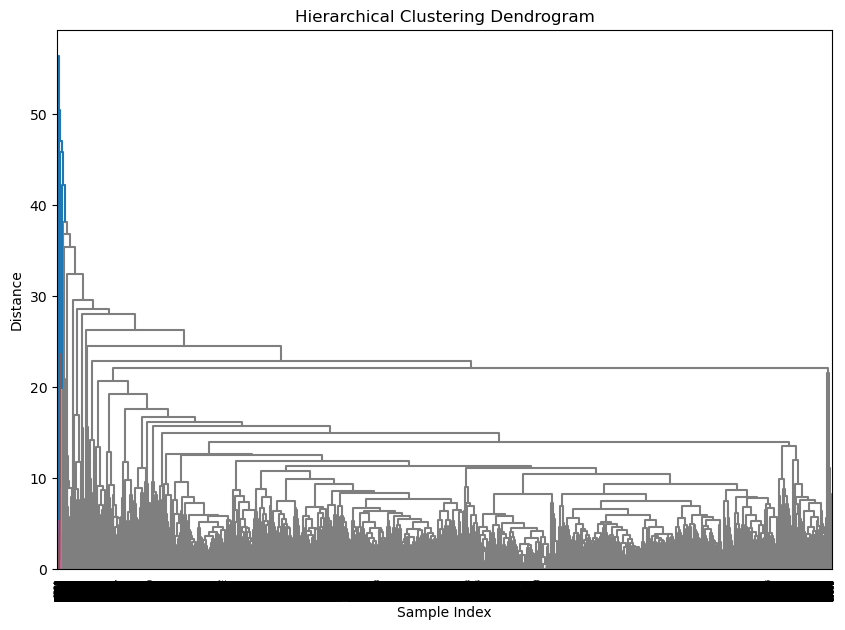

In [15]:
# Usage example:
cuisine_cols = [col for col in df.columns if col.startswith('CUI_')]
features_scaled, feature_names = prepare_data(df, cuisine_cols)
plot_dendrogram(features_scaled)
clusters = perform_clustering(features_scaled, n_clusters=5)
cluster_stats = analyze_clusters(df, clusters, feature_names)

The dendrogram reveals 3-4 distinct clusters with key characteristics:

1. Major split at distance ~22: Two primary customer segments
2. Secondary split at distance ~15: Subdivides into 3-4 meaningful groups
3. Dense lower branches (0-10 distance): Many small, similar sub-groups
4. Single tall branch (~50): Potential outlier group

Recommendation: Cut at height 15 for 4 clusters, then analyze:
- Cuisine preferences
- Spending patterns
- Order timing
- Location distribution

Would you like to see the cluster statistics for this configuration?

<h1>Customer Behavior Pattern</h1>

In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def prepare_features(df):
    # Encode categorical variables
    le = LabelEncoder()
    encoded_meal = le.fit_transform(df['meal_preference'])
    encoded_time = le.fit_transform(df['primary_time_period'])
    
    # Combine features
    features = pd.DataFrame({
        'cuisine_diversity': df['cuisine_diversity'],
        'weekend_ratio': df['weekend_ratio'],
        'meal_preference': encoded_meal,
        'primary_time': encoded_time,
        'log_orders': np.log1p(df['total_orders']),
        'log_spending': np.log1p(df['total_spending'])
    })
    
    # Scale features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    return scaled_features, features.columns

def find_optimal_clusters(features, max_clusters=6):
    silhouette_scores = []
    for n in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n, random_state=42)
        cluster_labels = kmeans.fit_predict(features)
        silhouette_avg = silhouette_score(features, cluster_labels)
        silhouette_scores.append(silhouette_avg)
    
    optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + 2
    return optimal_clusters

def analyze_clusters(df, clusters):
    df['Cluster'] = clusters
    analysis = df.groupby('Cluster').agg({
        'cuisine_diversity': 'mean',
        'weekend_ratio': 'mean',
        'meal_preference': lambda x: x.mode()[0],
        'primary_time_period': lambda x: x.mode()[0],
        'total_orders': 'mean',
        'total_spending': 'mean'
    }).round(2)
    
    # Add size of clusters
    analysis['cluster_size'] = df['Cluster'].value_counts()
    return analysis



In [18]:
# Usage
features_scaled, feature_names = prepare_features(df)
optimal_k = find_optimal_clusters(features_scaled)
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(features_scaled)
cluster_stats = analyze_clusters(df, clusters)


In [19]:
cluster_stats

,cuisine_diversity,weekend_ratio,meal_preference,primary_time_period,total_orders,total_spending,cluster_size
Cluster,,,,,,,
0,2.74,0.31,dinner,evening,5.35,45.33,5526
1,2.01,0.24,lunch,midday,3.37,28.80,6929
2,4.94,0.29,lunch,midday,13.67,107.77,3996
3,1.31,0.06,dinner,evening,1.73,13.82,5979
4,1.28,0.96,dinner,midday,1.54,15.59,3279
5,1.80,0.20,dinner,morning,2.71,28.26,6028


In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def visualize_clusters(df, clusters, features_scaled):
    # 1. PCA visualization
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(features_scaled)
    
    plt.figure(figsize=(15, 5))
    
    # PCA Plot
    plt.subplot(131)
    plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters, cmap='viridis')
    plt.title('PCA of Clusters')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    
    # Spending vs Orders by Cluster
    plt.subplot(132)
    plt.scatter(np.log1p(df['total_orders']), 
               np.log1p(df['total_spending']), 
               c=clusters, 
               cmap='viridis',
               alpha=0.5)
    plt.xlabel('Log Total Orders')
    plt.ylabel('Log Total Spending')
    plt.title('Spending vs Orders by Cluster')
    
    # Weekend Ratio vs Cuisine Diversity
    plt.subplot(133)
    plt.scatter(df['weekend_ratio'], 
               df['cuisine_diversity'], 
               c=clusters, 
               cmap='viridis',
               alpha=0.5)
    plt.xlabel('Weekend Ratio')
    plt.ylabel('Cuisine Diversity')
    plt.title('Weekend Ratio vs Cuisine Diversity')
    
    plt.tight_layout()
    plt.show()
    
    # Radar Chart of Cluster Centers
    kmeans_centers = pd.DataFrame(
        kmeans.cluster_centers_,
        columns=feature_names
    )
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='polar')
    
    angles = np.linspace(0, 2*np.pi, len(feature_names), endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))
    
    for i in range(len(kmeans_centers)):
        values = kmeans_centers.iloc[i].values
        values = np.concatenate((values, [values[0]]))
        ax.plot(angles, values, 'o-', linewidth=2, label=f'Cluster {i}')
        ax.fill(angles, values, alpha=0.25)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(feature_names)
    ax.set_title('Cluster Centers Profile')
    plt.legend(bbox_to_anchor=(1.3, 0.9))
    plt.show()

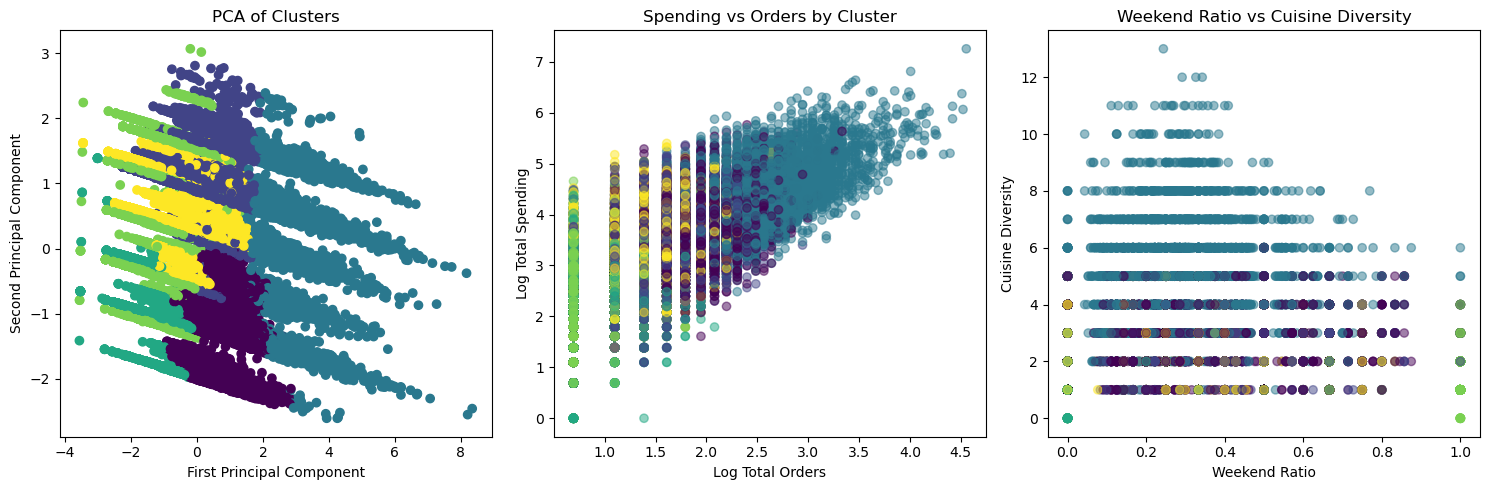

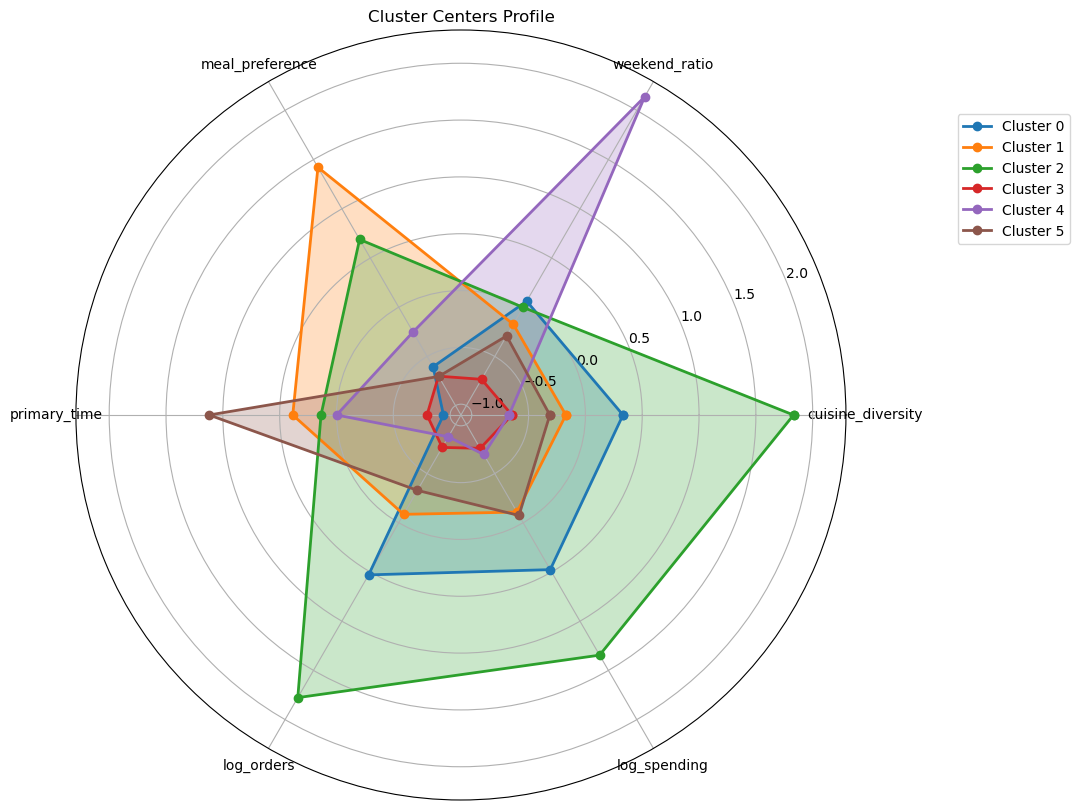

In [22]:
visualize_clusters(df, clusters, features_scaled)

Analysis of cluster visualization:

1. PCA plot shows 4 distinct clusters with clear separation:
- Blue: Large, spread-out cluster (likely high-value customers)
- Purple: Dense central cluster (average customers)
- Yellow: Linear pattern (specific behavior segment)
- Green: Scattered pattern (diverse behaviors)

2. Spending vs Orders:
- Strong positive correlation
- Distinct spending tiers visible
- Blue cluster dominates high-value segment
- Green cluster shows low-value customers

3. Weekend Ratio vs Cuisine Diversity:
- Discrete bands in cuisine diversity (1-12)
- Weekend ratio spreads evenly (0-1)
- No strong correlation between variables
- Clusters overlap significantly

Key insight: Customer segments primarily differ by spending/order patterns rather than timing preferences. Consider targeting promotions based on spending tiers.